In [ ]:
# The approximate bayesian computation is used when the likelihood is complex function
# which must be computed.

# The first example given here is approximating a tumor growth. The author has a correspondent
# whose tumor reached the radius of 15 cm at detection, he wonder if it could have formed within
# the last nine years.
#
# The known parameters from the literature are
#
# - The distribution of the reciprocal of doubling time (RDT) that measures the
# progress of doubling in volume per year. (RDT=1 means it doubles in a year, RDT=3 means it 8x in a year,
# and RDT=-1 means it halves in a year).
#
# - the minimal detected size is 0.3 cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: >

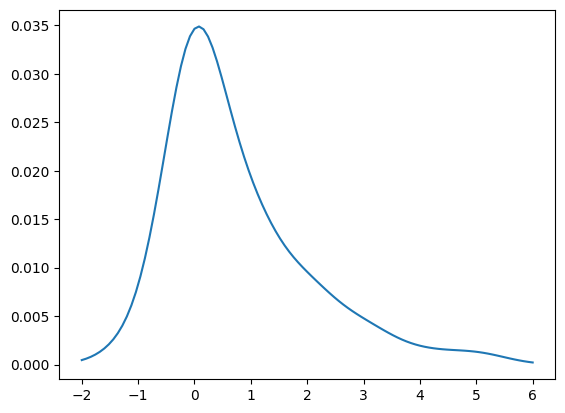

In [5]:
# First we find the distribution. According to https://sci-hub.se/10.1148/radiol.2501071712
# the median RDT is 0.45 and the mean is 0.77. The range is -1.47 to 5.06.
%load_ext autoreload
# so I can change mcmc.py without reloading manually
%autoreload 3

import numpy as np
import pandas as pd
from utils import kde_from_samples
rdt_samples = [-1]*2 + [0]*29 + [1]*11 + [2]*6 + [3]*3 + [4,5]
pmf_rdt = kde_from_samples(rdt_samples, np.linspace(-2, 6, 101))
pmf_rdt.plot()

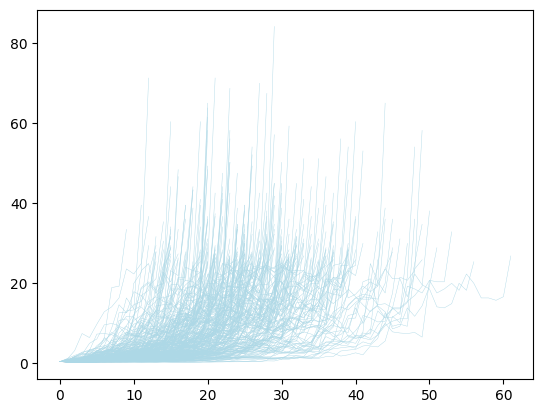

In [76]:
import pandas as pd

def radius_to_volume(radius):
    return (4/3) * 3.14 * (radius ** 3)

def volume_to_radius(volume):
    return (volume / (4/3) / 3.14) ** (1/3)

def simulate_growth(pmf_rdt, init_radius, max_radius):
    """simulate the growth of a tumor."""
    age = 0
    interval = 365 # once every year
    radius = init_radius
    log = [(0, radius)]
    while True:
        if radius > max_radius:
            break
        volume = radius_to_volume(radius)
        rdt = pmf_rdt.choice()
        doubling = rdt * (interval / 365)
        volume *= 2**doubling
        age += 1
        radius = volume_to_radius(volume)
        log.append((age, radius))

    ages = [a for (a, r) in log]
    radii = [r for (a, r) in log]
    return pd.Series(radii, ages)

growth_data = [simulate_growth(pmf_rdt, 0.3, 25) for _ in range(300)]
for series in growth_data:
    series.plot(legend=False, color='lightblue', linewidth=0.3)

<Axes: title={'center': 'Years it takes to grow to given size'}>

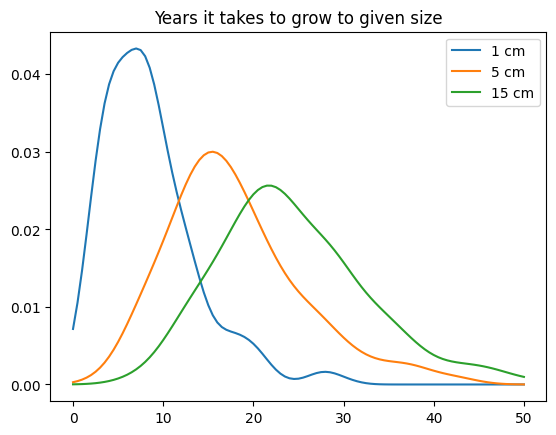

In [79]:
# now we can tell how likely a tumor of radius 15 formed within 9 years ago.

from scipy.interpolate import interp1d
from utils import kde_from_samples

def interpolate_ages(data, radius):
    """calculate the ages it take to grow to a specified radius"""
    ages = []
    for series in data:
        interp = interp1d(series.values, series.index)
        age = float(interp(radius))
        ages.append(age)
    return ages

qs = np.linspace(0, 50, 101)
kde_from_samples(interpolate_ages(growth_data, 1), qs).plot(
    label="1 cm", legend=True,
    title="Years it takes to grow to given size")
kde_from_samples(interpolate_ages(growth_data, 5), qs).plot(label="5 cm", legend=True)
kde_from_samples(interpolate_ages(growth_data, 15), qs).plot(label="15 cm", legend=True)

In [81]:
# we finally calculate the probability a 15 cm tumor started within 9 years ago.
pmf_15cm = kde_from_samples(interpolate_ages(growth_data, 15), qs)
pmf_15cm.prob_le(9)

0.021589846704669804

In [ ]:
# So this concludes the idea of ABC:
#
# 1. we have a prior distribution of parameters (e.g. pmf_rdt)
# 2. we simulate the system that generates the data (simulate_growth: pmf_rdt -> growth)
# 3. we apply a criterion on the data to get a posterior we want
#  (interpolate_ages: growth -> [ages] --(kde)--> posterior_pmf_for_ages)

(43.71760545416025, 37)

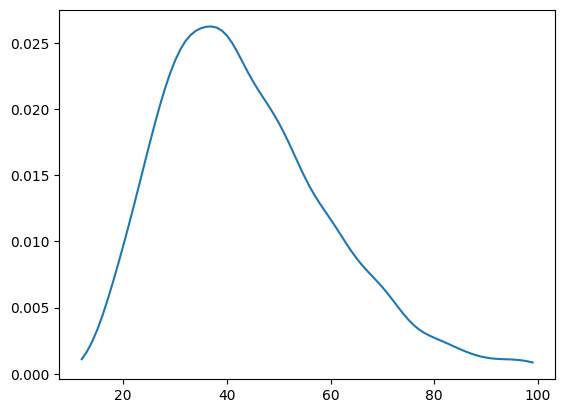

In [95]:
# Exercise 20-1: socks problem. Suppose you pull 11 socks out of a laundry and found
# no two of them make a matched pair. Estimate the number of socks in the laundry.
#
# assumption: the laundry contains n_pairs pairs of socks plus n_odds unpaired socks. we also assume
# all socks are different (i.e. at most two of the same look).
#
# the prior distribution suggested:
# - n_pairs follows negative binom distribution with mu=30 and std=15
# - proportion_paired (i.e. n_pairs/n_odd) follows a beta distribution with alpha=15 and beta=2
from random import shuffle

def ex_20_1_simulate_single(n_pairs, prop_paired, n_pulled):
    n_total = round(n_pairs / prop_paired)
    n_odds = n_total - n_pairs
    socks = list(range(0, n_pairs)) * 2 + list(range(n_pairs, n_pairs + n_odds))
    shuffle(socks)
    pulled = socks[:n_pulled]
    n_overlap = len(pulled) - len(set(pulled))
    return (n_total, n_overlap)

def ex_20_1_simulate(n_pairs_dist, prop_paired_dist, n_pulled, n_samples):
    n_pairs = list(n_pairs_dist.rvs(size = n_samples))
    prop_paired = list(prop_paired_dist.rvs(size = n_samples))
    priors = zip(n_pairs, prop_paired)
    data = [ex_20_1_simulate_single(n_pairs, prop_paired, n_pulled) for (n_pairs, prop_paired) in priors]
    return data

def ex_20_1_criterion(data, n_overlap_goal):
    accepted = []
    for n_total, n_overlap in data:
        if n_overlap == n_overlap_goal:
            accepted.append(n_total)
    return accepted

from scipy.stats import nbinom, beta
def ex_20_1():
    # I have to deduce the correct r and p parameter from the expected mean and std. formula was found
    # on wikipedia.
    n_pairs_dist = nbinom(30*30/(15*15-30), (30/15)/15)
    assert(n_pairs_dist.mean() == 30 and n_pairs_dist.std() == 15)
    prop_paired_dist = beta(15, 2)
    data = ex_20_1_simulate(n_pairs_dist, prop_paired_dist, 11, 10000)
    accepted = ex_20_1_criterion(data, 0)
    qs = np.arange(12, 100)
    pmf = kde_from_samples(accepted, qs)
    return pmf

posterior_total_pmf = ex_20_1()
posterior_total_pmf.plot()
(posterior_total_pmf.mean(), posterior_total_pmf.max_prob())

In [96]:
# I found the example for this exercise more representative than the example of tumor growth.
# Especially on what's meant by "accepting" a computation.